# 데이터셋 확인 및 분리

In [1]:
from sklearn.datasets import fetch_20newsgroups

# 20개의 토픽 중 선택하고자 하는 토픽을 리스트로 생성
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# 학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),  # 메일 내용에서 hint가 되는 부분을 삭제 - 순수하게 내용만으로 분류
                                      categories=categories)
# 검증 데이터셋을 가져옴
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

In [2]:
X_train = newsgroups_train.data     # 학습 데이터셋 문서
y_train = newsgroups_train.target   # 학습 데이터셋 라벨

X_test = newsgroups_test.data       # 검증 데이터셋 문서
y_test = newsgroups_test.target     # 검증 데이터셋 라벨

# PCA를 이용한 차원 축소

**문서 분류를 위한 데이터 준비 (TF-IDF 벡터)**

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
cachedStopWords = stopwords.words("english")
RegTok = RegexpTokenizer("[\w']{3,}")               # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english'))     # 영어 불용어를 가져옴

In [5]:
def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    # porter stemmer 적용
    features = (list(map(lambda token: PorterStemmer().stem(token),words)))
    return features

In [6]:
tfidf = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train)    # train set을 변환
X_test_tfidf = tfidf.transform(X_test)          # test set을 변환

**로지스틱 회귀에 대한 성능 차이 확인**

차원 축소 전

In [7]:
from sklearn.linear_model import LogisticRegression 

LR_clf = LogisticRegression()       # 분류기 선언
LR_clf.fit(X_train_tfidf, y_train)  # train data를 이용하여 분류기를 학습

print('Train set score: {:.3f}'.format(LR_clf.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(LR_clf.score(X_test_tfidf, y_test))) 

Train set score: 0.962
Test set score: 0.761


차원 축소 후

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2000, random_state = 7)    # 차원 축소 20085 -> 2000, reproducible
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

print('Original tfidf matrix shape:', X_train_tfidf.shape)
print('PCA Converted matrix shape:', X_train_pca.shape)
print('Sum of explained variance ratio: {:.3f}'.format(pca.explained_variance_ratio_.sum()))    # 축소 전 분산과의 비율 (1이면 축소 전 분산을 모두 설명)

Original tfidf matrix shape: (2034, 20085)
PCA Converted matrix shape: (2034, 2000)
Sum of explained variance ratio: 1.000


In [9]:
LR_clf.fit(X_train_pca, y_train)

print('Train set score: {:.3f}'.format(LR_clf.score(X_train_pca, y_train)))
print('Test set score: {:.3f}'.format(LR_clf.score(X_test_pca, y_test)))

Train set score: 0.962
Test set score: 0.761


**라쏘 회귀와의 성능 차이 확인**

라쏘 회귀를 이용한 특성 선택

In [10]:
import numpy as np

lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', C=1) 
lasso_clf.fit(X_train_tfidf, y_train) 

print('Train set score: {:.3f}'.format(lasso_clf.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(lasso_clf.score(X_test_tfidf, y_test)))

# 계수(coefficient) 중에서 0이 아닌 것들의 개수를 출력
print('#Used features count: {}'.format(np.sum(lasso_clf.coef_ != 0)), 'out of', X_train_tfidf.shape[1]) 

Train set score: 0.790
Test set score: 0.718
#Used features count: 321 out of 20085


하쏘 회귀에서 선택된 특성의 차원 수와 동일한 차원 수로 축소 후 로지스틱 회귀

In [11]:
pca = PCA(n_components=321, random_state=7)

X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

print('PCA Converted X shape:', X_train_pca.shape)
print('Sum of explained variance ratio: {:.3f}'.format(pca.explained_variance_ratio_.sum()))

PCA Converted X shape: (2034, 321)
Sum of explained variance ratio: 0.437


In [12]:
LR_clf.fit(X_train_pca, y_train)

print('Train set score: {:.3f}'.format(LR_clf.score(X_train_pca, y_train)))
print('Test set score: {:.3f}'.format(LR_clf.score(X_test_pca, y_test)))

Train set score: 0.875
Test set score: 0.751


차원 수를 획기적으로 줄였을 때 (20085 -> 100)

In [13]:
pca = PCA(n_components=100, random_state=7)

X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

print('PCA Converted X shape:', X_train_pca.shape)
print('Sum of explained variance ratio: {:.3f}'.format(pca.explained_variance_ratio_.sum()))

PCA Converted X shape: (2034, 100)
Sum of explained variance ratio: 0.211


In [14]:
LR_clf.fit(X_train_pca, y_train)

print('Train set score: {:.3f}'.format(LR_clf.score(X_train_pca, y_train)))
print('Test set score: {:.3f}'.format(LR_clf.score(X_test_pca, y_test)))

Train set score: 0.807
Test set score: 0.738


# LSA를 이용한 차원 축소와 의미 파악

**차원 축소와 성능**

In [15]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2000, random_state=7)   # 차원 축소 20085 -> 2000, reproducible

X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

print('LSA Converted X shape:', X_train_lsa.shape)
print('Sum of explained variance ratio: {:.3f}'.format(svd.explained_variance_ratio_.sum()))

LSA Converted X shape: (2034, 2000)
Sum of explained variance ratio: 1.000


In [16]:
LR_clf.fit(X_train_lsa, y_train)

print('Train set score: {:.3f}'.format(LR_clf.score(X_train_lsa, y_train)))
print('Test set score: {:.3f}'.format(LR_clf.score(X_test_lsa, y_test)))

Train set score: 0.962
Test set score: 0.761


차원 수를 획기적으로 줄였을 때 (20085 -> 100)

In [17]:
svd = TruncatedSVD(n_components=100, random_state=1)    # 차원 축소 20085 -> 100, reproducible

X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

print('LSA Converted X shape:', X_train_lsa.shape)
print('Sum of explained variance ratio: {:.3f}'.format(svd.explained_variance_ratio_.sum()))

LSA Converted X shape: (2034, 100)
Sum of explained variance ratio: 0.209


In [18]:
LR_clf.fit(X_train_lsa, y_train)

print('Train set score: {:.3f}'.format(LR_clf.score(X_train_lsa, y_train)))
print('Test set score: {:.3f}'.format(LR_clf.score(X_test_lsa, y_test)))

Train set score: 0.810
Test set score: 0.745


**의미 기반의 문서 간 유사도 계산** (유사도가 높은 20개의 문서)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

print('사용된 전체 카테고리:', newsgroups_train.target_names)
print('첫 문서의 카테고리:', y_train[0])

사용된 전체 카테고리: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
첫 문서의 카테고리: 1


카운트 벡터

In [20]:
# 변환된 count vector와 기존 값들과의 similarity 계산
sim_result = cosine_similarity([X_train_lsa[0]], X_train_lsa) 
print("Top 20 유사도(lsa):\n", sorted(sim_result[0].round(2), reverse=True)[:20])

sim_index = (-sim_result[0]).argsort()[:20]
print('Top 20 유사 뉴스의 인덱스(lsa):\n', sim_index)

sim_labels = [y_train[i] for i in sim_index]
print('Top 20 유사 뉴스의 카테고리(lsa):\n', sim_labels)

Top 20 유사도(lsa):
 [1.0, 0.74, 0.74, 0.72, 0.7, 0.7, 0.69, 0.67, 0.66, 0.65, 0.65, 0.65, 0.63, 0.62, 0.62, 0.62, 0.57, 0.57, 0.55, 0.54]
Top 20 유사 뉴스의 인덱스(lsa):
 [   0 1957 1674  501 1995 1490  790 1902 1575 1209 1728  892 1892  998
 1038 1826 1290 1089  867  151]
Top 20 유사 뉴스의 카테고리(lsa):
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


TF-IDF (LSA에 비해 문서 간 거리가 멀어 차원의 저주가 발생)

In [21]:
sim_result = cosine_similarity(X_train_tfidf[0], X_train_tfidf) 
print("Top 20 유사도(tfidf):\n", sorted(sim_result[0].round(2), reverse=True)[:20])

sim_index = (-sim_result[0]).argsort()[:20]
print('Top 20 유사 뉴스의 인덱스(tfidf):\n', sim_index)

sim_labels = [y_train[i] for i in sim_index]
print('Top 20 유사 뉴스의 카테고리(tfidf):\n', sim_labels)

Top 20 유사도(tfidf):
 [1.0, 0.3, 0.22, 0.21, 0.19, 0.19, 0.19, 0.17, 0.16, 0.16, 0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.14]
Top 20 유사 뉴스의 인덱스(tfidf):
 [   0 1575 1892 1490  501 1290 1013  998 1636 1705 1995 1957 1664  651
 1038  429 1089 1209 1728 1803]
Top 20 유사 뉴스의 카테고리(tfidf):
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**잠재된 토픽의 분석**

In [22]:
svd = TruncatedSVD(n_components=10, random_state=1)     # 차원이 크면 토픽을 파악하기 힘들다

X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

print('LSA Converted X shape:', X_train_lsa.shape)
print('Sum of explained variance ratio: {:.3f}'.format(svd.explained_variance_ratio_.sum()))

terms = tfidf.get_feature_names_out()

def get_topics(model, feature_names, n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx+1), 
              [feature_names[i] for i in topic.argsort()[:-n - 1:-1]])
        
get_topics(svd, terms)

LSA Converted X shape: (2034, 10)
Sum of explained variance ratio: 0.045
Topic 1: ['would', 'one', 'god', 'think', 'use', 'peopl', 'know', 'like', 'say', 'space']
Topic 2: ['file', 'imag', 'thank', 'program', 'graphic', 'space', 'format', 'use', 'color', 'ftp']
Topic 3: ['space', 'orbit', 'nasa', 'launch', 'shuttl', 'satellit', 'year', 'moon', 'lunar', 'cost']
Topic 4: ['moral', 'object', 'system', 'valu', 'goal', 'think', 'anim', 'absolut', 'natur', 'defin']
Topic 5: ['ico', 'bobb', 'tek', 'beauchain', 'bronx', 'manhattan', 'sank', 'queen', 'vice', 'blew']
Topic 6: ['god', 'file', 'imag', 'object', 'moral', 'exist', 'space', 'format', 'system', 'color']
Topic 7: ['file', 'islam', 'imag', 'cview', 'use', 'format', 'color', 'muslim', 'religion', 'peopl']
Topic 8: ['post', 'file', 'space', 'islam', 'read', 'cview', 'format', 'articl', 'group', 'moral']
Topic 9: ['christian', 'graphic', 'imag', 'jesu', 'book', 'data', 'group', 'softwar', 'law', 'code']
Topic 10: ['exist', 'atheism', 'athe

**단어 간 의미 유사도 분석**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)        # 단어 관점에서 전처리를 다시 해야함
X_train_tfidf = tfidf.fit_transform(X_train)    # train set을 변환

svd = TruncatedSVD(n_components=100, random_state=1)
X_train_lsa = svd.fit_transform(X_train_tfidf)

print('components_의 shape:', svd.components_.shape)
print('singular_values_의 shape:', svd.singular_values_.shape)

t_words = np.diag(svd.singular_values_).dot(svd.components_).T
print('변환된 단어-잠재의미 행렬의 shape:', t_words.shape)

components_의 shape: (100, 1000)
singular_values_의 shape: (100,)
변환된 단어-잠재의미 행렬의 shape: (1000, 100)


In [24]:
# space 카테고리에 해당하는 벡터를 가져옴
source = t_words[np.where(tfidf.get_feature_names_out() == 'space')[0][0]]

# 변환된 count vector와 기존 값들과의 similarity 계산
sim_result = cosine_similarity([source], t_words)
print("Top 20 유사도(tfidf):", sorted(sim_result[0].round(2), reverse=True)[:20])

sim_index = (-sim_result[0]).argsort()[:20]
print('Top 20 유사 뉴스의 인덱스(tfidf):', sim_index)

sim_labels = [tfidf.get_feature_names_out()[i] for i in sim_index]
print('Top 20 유사 뉴스의 카테고리(tfidf):', sim_labels)

Top 20 유사도(tfidf): [1.0, 0.73, 0.72, 0.69, 0.66, 0.58, 0.56, 0.56, 0.54, 0.54, 0.52, 0.52, 0.52, 0.51, 0.51, 0.5, 0.5, 0.49, 0.48, 0.47]
Top 20 유사 뉴스의 인덱스(tfidf): [812 314 754 829 594 679 720 650 785 565 101 435 606 545 854 746 669 856
 611 564]
Top 20 유사 뉴스의 카테고리(tfidf): ['space', 'exploration', 'sci', 'station', 'office', 'propulsion', 'reports', 'planetary', 'shuttle', 'national', 'astro', 'international', 'operations', 'missions', 'technical', 'satellites', 'probes', 'telescope', 'orbiter', 'nasa']


# t-SNE를 이용한 시각화와 차원축소의 효과

t-SNE (t-distributed stochastic neighbor embedding) : 매니폴드(Manifold) 학습의 하나로 높은 차원의 복잡한 데이터를 2차원 또는 3차원에 차원 축소하여 시각화 하는 방법

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [46]:
def tsne_graph(tsne_2, label, lim=None):
    colors = {0:'cyan', 1:'magenta', 2:'green', 3:'black'}
    x = tsne_2[:,0]     # 압축된 첫 차원을 x축으로 이용
    y = tsne_2[:,1]     # 압축된 둘째 차원은 y축으로 이용
    plt.figure(figsize=(15,10))
    if lim == None:
        lim = [min(x), max(x), min(y), max(y)]
    plt.xlim(lim[0], lim[1])
    plt.ylim(lim[2], lim[3])
    
    for i in range(len(x)):
        # 각 값에 대해 y값 즉 label에 따라 색을 바꿔가며 text로 그래프에 출력
        if (lim[0] < x[i] < lim[1]) and (lim[2] < y[i] < lim[3]):
            plt.text(x[i], y[i], label[i], color = colors[label[i]])
    plt.show()

**TF-IDF 시각화**

카테고리에 관계없이 원형으로 분포되어 있음, 사실상 카테고리 구분이 어렵다.

In [47]:
from sklearn.manifold import TSNE

tfidf = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train)    # train set을 변환
X_test_tfidf = tfidf.transform(X_test)          # test set을 변환

tsne = TSNE(n_components=2, random_state=7)
tsne_tfidf = tsne.fit_transform(X_train_tfidf)

print('TSNE dimension:', tsne_tfidf.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


TSNE dimension: (2034, 2)


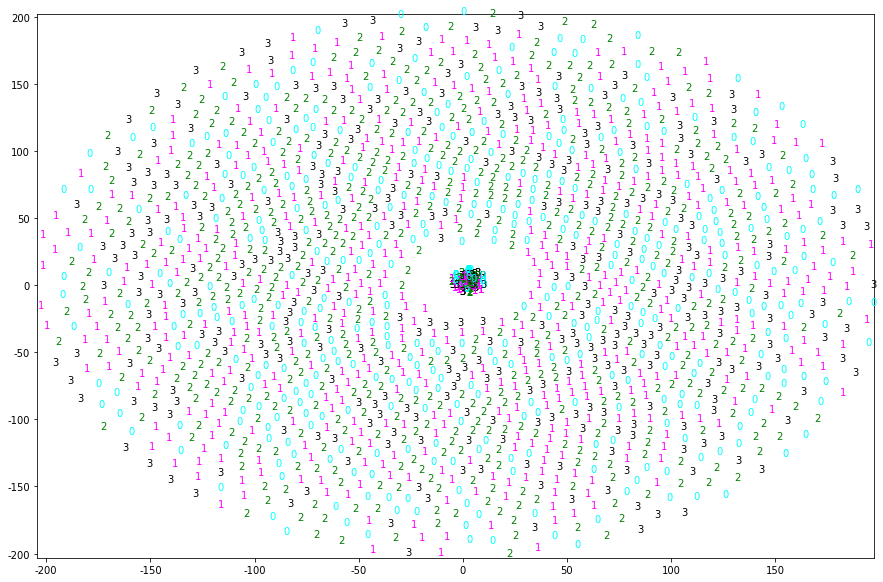

In [48]:
tsne_graph(tsne_tfidf, y_train)

**LSA로 차원 축소 후 시각화**

카테고리를 어느정도 구분이 가능할 정도로 분포된 영역이 보인다. 다만 0, 3의 카테고리는 무신론과 종교로 어느정도 유사한 주제를 다루고 있어 겹치는 부분이 발생한다.

In [29]:
svd = TruncatedSVD(n_components=100, random_state=1)    # 차원 축소 20085 -> 100, reproducible

X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

tsne_lsa = tsne.fit_transform(X_train_lsa)

print('TSNE dimension:', tsne_lsa.shape)
print('Selected categories:', newsgroups_train.target_names)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


TSNE dimension: (2034, 2)
Selected categories: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


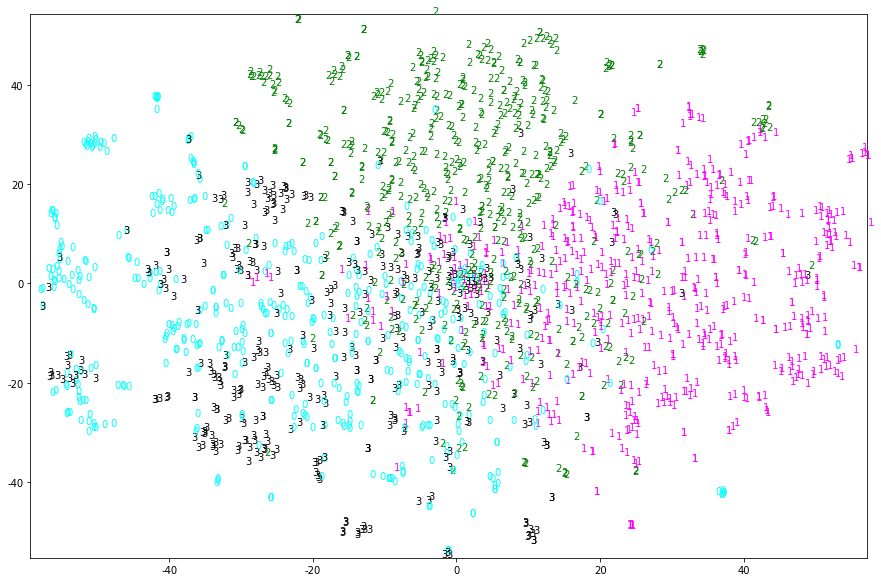

In [49]:
tsne_graph(tsne_lsa, y_train)